# Problem Set 2
### Lukas Hager,  ECON 532
___

## Market Simulation
**For each of these two simulations, compare the distribution of prices, profits and consumer surplus. For consumer surplus, simulate draws of consumers from the true distribution and calculate their optimal purchasing decision and welfare**
___
To get prices, we simply squeeze the variable `P_opt` to be one dimensional and plot a histogram. To get profit and consumer surplus, we must simulate customers; arbitrarily, we take the number of customers to be 1,000. Then, we calculate 
$$\pi_{jm} = \text{Market Share} \times \text{Consumers} \times \left(p_{jm} - mc_{jm}\right)$$
and
$$CS_{im} = \frac{1}{\alpha_{i}}\max_{j}U_{ijm}$$

In [28]:
# import libraries
import numpy as np
import numpy.random as rand
import pandas as pd
import scipy as sp
from scipy.io import loadmat
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,5)

source_path = '/Users/hlukas/git/uw_grad_school_code/ECON-532/Assignment 2/pset2_upload/Simulated Data/{}markets{}products.mat'
gamma = np.array([2,1,1]).reshape(3,1)
alpha = 1.
sigma_alpha = 1.
beta = np.array([5.,1.,1.]).reshape((3,1))

In [29]:
# function to import the data into python

def import_data(mkts,prods):
    mat_data = loadmat(source_path.format(mkts,prods))
    variable_names = [x for x in mat_data.keys() if x not in ['__header__', '__version__', '__globals__']]
    return([mat_data[x] for x in variable_names])

In [30]:
# function to plot prices

def plot_prices(mkts, prods):
    # import data
    x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)
    
    p_flat = P_opt.reshape(prods * mkts)
    plt.hist(p_flat, bins=int(np.ceil(p_flat.max())*2), ec='black', range=(0, np.ceil(p_flat.max())))
    plt.title('Price Distribution ({} Products, {} Markets)'.format(prods, mkts))
    plt.xlabel('Price')
    plt.ylabel('Products')
    plt.show()

In [31]:
def plot_profit(mkts, prods):
    # import data
    x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)
    
    # get consumers
    n_consumers = alphas.shape[1]
    
    # get the marginal cost
    mc_jm = np.column_stack([np.ones(prods * mkts),w, Z]) @ gamma + eta
    markup = P_opt.T - mc_jm.reshape((mkts, prods))

    profit = markup * shares.T * n_consumers
    
    profit_flat = profit.reshape(prods * mkts)
    plt.hist(profit_flat, bins='fd', ec = 'black')
    plt.title('Profit Distribution ({} Products, {} Markets, {} Consumers)'.format(prods, mkts, n_consumers))
    plt.xlabel('Profit')
    plt.ylabel('Products')

The way that we calculate consumer surplus requires a little more explication. We know that
$$U_{ijm} = X_{jm}\beta - p_{jm}\alpha_i + \xi_{jm} + \epsilon_{ijm}$$
We can instead write utility as a $im\times j$ matrix, so that each row represents a consumer/market combination, and each column is a given product. We can do this by getting the utility that doesn't depend on the consumer, stacking that matrix $i$ times, stacking the price and $\xi$ matrix $i$ times, and creating an $\alpha$ matrix by repeating each $\alpha_i$ $j$ times:

In [50]:
def plot_cs(mkts, prods):
    # set a seed
    rand.seed(seed=2022)
    
    # import data
    x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)
    
    # get consumers
    n_consumers = alphas.shape[1]

    # get the alpha_i, reshape to be in the order first market -> last market 500 times
    alpha_i = alphas.reshape((n_consumers * mkts,1), order = 'F')

    # repeat the alpha_i for each market
    alpha_big = np.tile(alpha_i, (1,prods))

    # get the market-product level utility
    u_jm = (x1 @ beta + xi_all).reshape((mkts,prods))

    # create a big system
    u_big = np.tile(u_jm, (n_consumers,1))
    xi_big = np.tile(xi_all.reshape((mkts,prods)), (n_consumers,1))
    p_big = np.tile(P_opt.T, (n_consumers,1))
    ep_big = rand.gumbel(size = mkts * prods * n_consumers).reshape((mkts * n_consumers, prods))

    # get the CS
    u = u_big + xi_big - alpha_big * p_big + ep_big
    u_outside = np.concatenate([u, np.zeros(mkts * n_consumers).reshape((mkts * n_consumers, 1))], axis = 1)
    cs = u_outside.max(axis = 1) / alpha_i.squeeze()
    cs_mean = np.mean(cs.reshape((100,500), order = 'F'), axis = 1)
    
    # plot
    plt.hist(cs_mean.squeeze(), bins='auto', ec='black', range=(np.min([0., np.min(cs_mean)]), np.ceil(np.max(cs_mean))))
    plt.title('CS Distribution ({} Products, {} Markets, {} Consumers)'.format(prods, mkts, n_consumers))
    plt.xlabel('Surplus')
    plt.ylabel('Markets')
    plt.show()

#### Price Plots
___

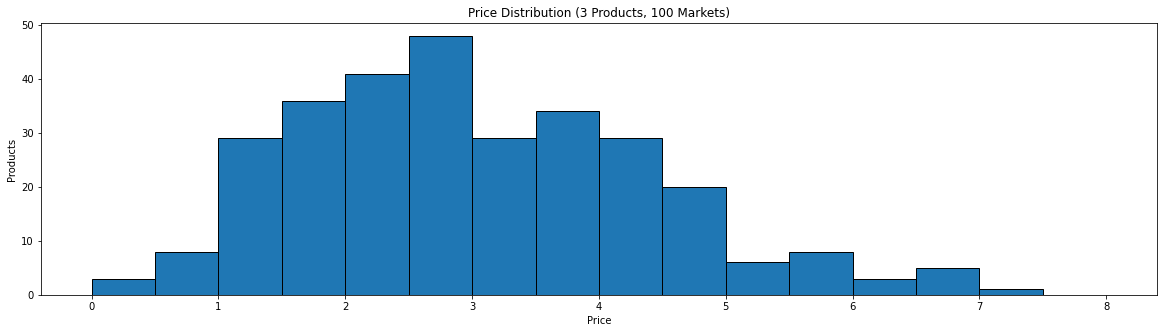

In [33]:
plot_prices(100,3)

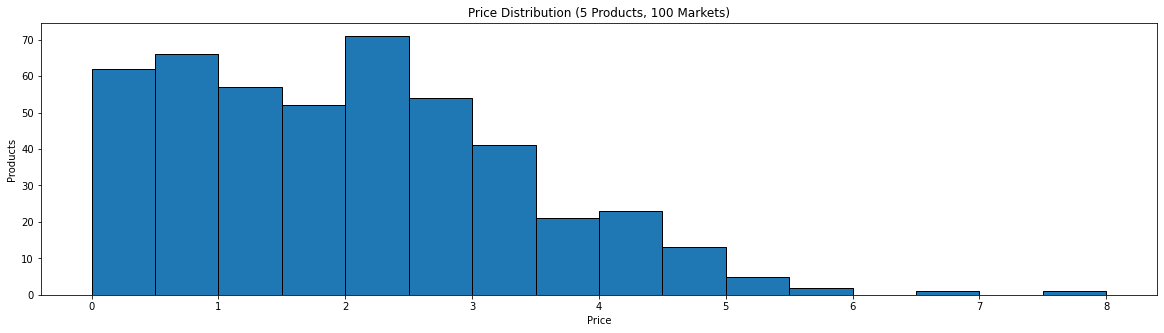

In [34]:
plot_prices(100,5)

Prices appear to be higher in the 3 good market compared to the 5 good market; this makes sense, as in a competitive market, more competition should drive down the prices that firms can charge.

#### Profit Plots
___

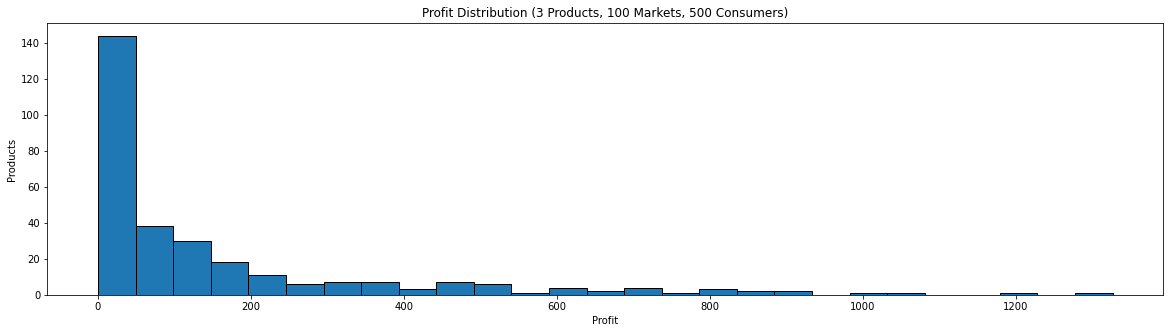

In [35]:
plot_profit(100,3)

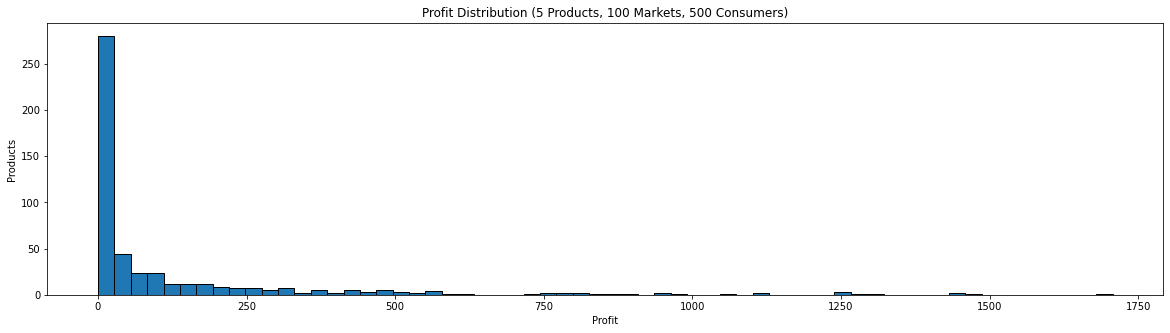

In [36]:
plot_profit(100,5)

The takeaway is similar to the above; when there is more competition, the profits of firms decrease, and the distribution is shifted towards lower amounts of profit.

#### Consumer Surplus Plots
___

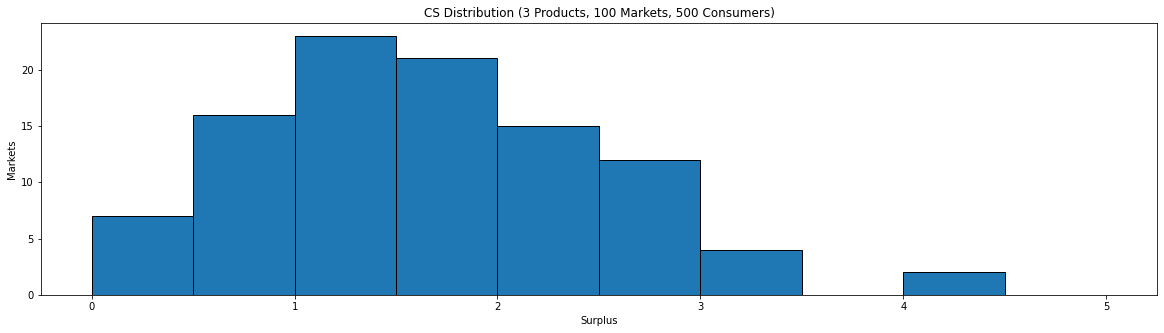

In [51]:
plot_cs(100,3)

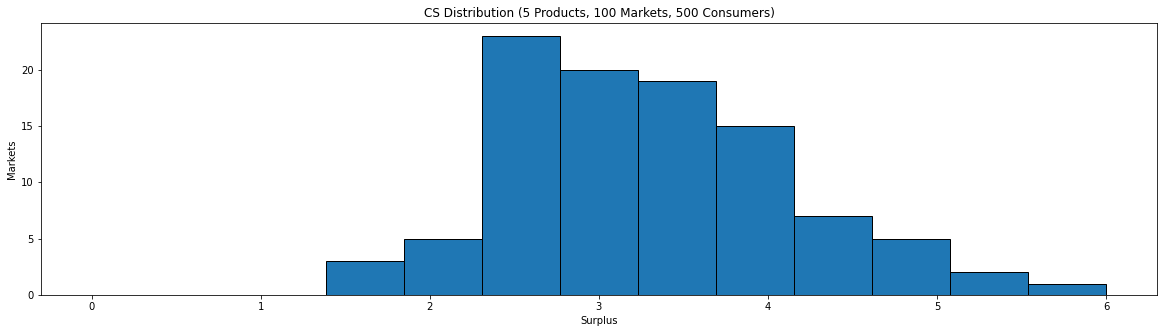

In [52]:
plot_cs(100,5)

Here, we see a large difference. In both simulations, a modal number of customers choose the outside option, but when there are more options, the consumer surplus increases significantly.

## BLP and Nevo Instruments
___

In [39]:
# import data
x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(100,3)

# xi/X
xi_X = np.mean(x1 * np.tile(xi_all, (1,3)), axis = 0)

# xi/p
xi_p = np.mean(P_opt.T * xi_all.reshape((100,3)))

# xi/p_hat
# to get p_hat, we compute average prices across other markets
p_hat = np.tile(
    np.array([np.mean(np.delete(P_opt.T,x,0)) for x in range(len(P_opt.T))]).reshape((100,1)),
    (1,3)
)

p_hat = np.row_stack([np.mean(np.delete(P_opt.T,x,0), axis = 0) for x in range(len(P_opt.T))])

xi_p_hat = np.mean(p_hat * xi_all.reshape((100,3)))

In [40]:
xi_X

array([0.04346104, 0.02074192, 0.0355315 ])

In [41]:
xi_p

0.2949581371489729

In [42]:
xi_p_hat

0.14367954767468022

It appears that $\mathbb{E}[\xi_{jm}X_{jm}] \approx 0$ and $\mathbb{E}[\xi_{jm}\overline{p}_{jm}] \approx 0$, so these conditions are likely roughly valid. Additionally, using $p$ appears to be irrelevant if we use $\overline{p}$.

We cannot use BLP and Nevo instruments in this setting, as Nevo uses a dummy variable for brand (firm in our case), which means that the BLP instruments do not have any variance within a given firm. 

In [115]:
def get_shares(mkts,prods,alpha_i,P_opt,delta):
    # repeat the alpha_i for each market
    alpha_big = np.tile(alpha_i, (1,prods))
    
    # repeat the prices
    p_big = np.tile(P_opt.T, (n_consumers,1))
    
    # repeat delta
    delta_big = np.tile(delta, (n_consumers,1))
    
    # get the utility, no shocks
    u = delta_big - alpha_big * p_big - p_big
    
    # calculate individual probabilities
    denom = np.tile((1. + np.sum(np.exp(u), axis = 1)).reshape(-1,1), (1,prods))
    indiv_probs = np.exp(u) / denom
    
    # calculate the mean of the probabilities as shares (?)
    shares = []
    for i in range(mkts):
        shares.append(np.mean(indiv_probs[list(range(i, mkts * n_consumers, n_consumers))], axis = 0))
    
    return(np.row_stack(shares))

In [119]:
mkts = 10
prods = 3

# set a seed
rand.seed(seed=2022)

# import data
x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(mkts,prods)

# get number of consumers
n_consumers = alphas.shape[1]

# simulate consumers
alpha_i = rand.lognormal(size = n_consumers * mkts).reshape((-1,1))

# repeat the alpha_i for each market
alpha_big = np.tile(alpha_i, (1,prods))

# stack the prices
p_big = np.tile(P_opt.T, (n_consumers,1))

# set initial delta guess
delta_new = np.zeros(mkts * prods).reshape((mkts,prods))
delta_old = np.zeros(mkts * prods).reshape((mkts,prods))

while True:
    s_calc = get_shares(mkts,prods,alpha_i,P_opt,delta_old)
    delta_new = delta_old + np.log(shares.T) - np.log(s_calc)
    crit = np.max(np.abs(delta_new - delta_old))
    if crit > 1e-3:
        delta_old = delta_new
    else:
        break

In [121]:
P_opt.shape

(3, 10)

In [82]:
np.mean(get_shares(100,3)[[0,2,4]], axis = 0)

array([0.21310387, 0.54306706, 0.16730067])

In [86]:
np.mean(get_shares(100,3)[list(range(0,5,2))], axis = 0)

array([0.21310387, 0.54306706, 0.16730067])

In [95]:
# import data
x1,xi_all,w,eta,Z,alphas,P_opt,shares = import_data(100,3)

In [100]:
np.abs(shares.T[:6] - get_shares(100,3)[:6])

array([[3.85074496e-05, 1.27139064e-01, 8.94453406e-02],
       [8.34929342e-02, 4.33664614e-02, 5.28342953e-03],
       [2.55426860e-01, 9.61206424e-02, 2.15195189e-01],
       [3.96948480e-03, 1.46616926e-01, 9.90585176e-03],
       [2.25508542e-02, 4.35568771e-02, 5.81034630e-02],
       [1.22251924e-02, 1.34514628e-01, 4.60486696e-02]])

In [105]:
np.log(get_shares(100,3,np.zeros(150000).reshape((50000,3)))) - np.log(shares.T)

array([[ 0.27585635, -3.26570655, -2.13731999],
       [-2.12257329, -0.50075525, -2.09752722],
       [-3.45148125, -2.7267019 , -1.01630801],
       [-1.05792994, -2.95599139, -2.00536247],
       [-1.56327545, -2.64351859, -2.42432274],
       [-4.62116362, -4.46473676, -4.12214507],
       [-3.87337497, -3.73479828, -3.68860671],
       [-1.1863138 , -2.12161678, -2.81917095],
       [-0.33966118, -1.80463717, -3.72573481],
       [-1.44587416, -4.15348525,  0.27209328],
       [-2.11279923, -2.0636467 , -2.06411637],
       [-1.4844478 , -3.74990751, -3.46178981],
       [-0.67412795, -3.34452784, -2.63714775],
       [-6.40475878, -2.49935365, -3.24184756],
       [-1.7014982 , -2.0210996 , -4.57288277],
       [-3.27955767, -1.67897636, -3.49194714],
       [-2.4458837 , -4.39098411, -1.48406551],
       [-2.66496059, -2.85619692, -1.97362213],
       [-2.98847259, -1.85978837, -2.03060905],
       [-4.05299457, -4.55550583, -1.89715261],
       [-1.56017745, -3.00637214, -2.253